# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy - Modified: tech indicator

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [52]:
# install finrl library
# !git clone https://github.com/AI4Finance-LLC/FinRL-Library.git

In [53]:
import sys
sys.path.append("FinRL-Library")

In [54]:
# install packages
# !pip install yfinance

In [55]:
# !pip install stockstats

In [56]:
#!pip install git+https://github.com/quantopian/pyfolio

In [57]:
# ## install finrl library
#!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [58]:
import warnings
warnings.filterwarnings("ignore")

In [59]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models_modified2 import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [60]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [61]:
# from config.py start_date is a string
# config.START_DATE

In [62]:
print(config.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [63]:
# I changed the end datae to yesterday, original date is 2021-07-06
df = YahooDownloader(start_date = '1962-01-01',
                     end_date = '2022-03-21',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [64]:
df.head()

,date,open,high,low,close,volume,tic,day
0,1962-01-02,0.837449,0.837449,0.823045,0.189691,352350.0,BA,1
1,1962-01-02,1.604167,1.619792,1.588542,0.495432,163200.0,CAT,1
2,1962-01-02,0.000000,3.296131,3.244048,0.355684,105840.0,CVX,1
3,1962-01-02,0.092908,0.096026,0.092908,0.058263,841958.0,DIS,1
4,1962-01-02,0.000000,8.328744,8.272595,1.075039,40740.0,HON,1


In [65]:
df.tail()

,date,open,high,low,close,volume,tic,day
338854,2022-03-18,508.739990,510.679993,501.559998,506.119995,5059000.0,UNH,4
338855,2022-03-18,211.699997,219.259995,210.289993,219.110001,14608100.0,V,4
338856,2022-03-18,52.119999,52.290001,50.799999,50.799999,70348600.0,VZ,4
338857,2022-03-18,47.349998,47.450001,46.470001,47.360001,11368000.0,WBA,4
338858,2022-03-18,145.179993,145.570007,144.110001,145.440002,10407600.0,WMT,4


In [66]:
df.shape

(338859, 8)

In [67]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,1962-01-02,0.837449,0.837449,0.823045,0.189691,352350.0,BA,1
1,1962-01-02,1.604167,1.619792,1.588542,0.495432,163200.0,CAT,1
2,1962-01-02,0.000000,3.296131,3.244048,0.355684,105840.0,CVX,1
3,1962-01-02,0.092908,0.096026,0.092908,0.058263,841958.0,DIS,1
4,1962-01-02,0.000000,8.328744,8.272595,1.075039,40740.0,HON,1


In [68]:
len(df.tic.unique())

30

In [69]:
df.tic.value_counts()

BA      15158
CVX     15158
DIS     15158
HON     15158
IBM     15158
JNJ     15158
KO      15158
MRK     15158
PG      15158
CAT     15158
MCD     14023
MMM     13171
AXP     12559
WMT     12499
TRV     11686
WBA     10593
INTC    10593
JPM     10593
NKE     10413
AAPL    10405
HD      10210
AMGN     9770
VZ       9661
UNH      9432
MSFT     9079
CSCO     8084
GS       5758
CRM      4467
V        3526
DOW       757
Name: tic, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [70]:
# added indicators
tech_indicators = [    "boll_ub", "boll_lb", # this two are new
'macd',
 'rsi_30',
 'cci_30',
 'dx_30']

In [71]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicators,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [72]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,boll_ub,boll_lb,macd,rsi_30,cci_30,dx_30,turbulence
50612,1982-03-04,7.468750,7.531250,7.406250,1.577718,1882400.0,CVX,3,1.792936,1.551560,-0.078270,31.333779,-101.904067,49.409082,18.525929
32373,1974-12-12,0.416180,0.418749,0.398197,0.266096,1858692.0,DIS,3,0.339431,0.252632,-0.015858,38.837682,-122.897741,24.017084,8.859958
25550,1972-03-29,0.761317,0.781893,0.748971,0.241151,856575.0,BA,2,0.259086,0.211287,-0.003598,52.974874,-30.797416,4.440134,13.258124
134375,2015-05-20,165.707458,166.768646,164.875717,121.977974,2406114.0,IBM,2,122.903070,118.172892,1.762936,59.574602,73.225424,9.882703,2.090459
145599,2019-11-01,124.830002,125.139999,123.250000,117.287056,6010200.0,PG,4,120.124309,109.416778,0.964240,56.479909,70.967600,21.699574,15.898359


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [73]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_indicators)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 10, State Space: 81


In [74]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicators,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [75]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '1962-01-01'
train_end = '2020-12-01' #original is 2020-4-1
val_test_start = '2020-12-01' #original is 2020-4-1
val_test_end = '2022-03-21'#original is 2021-7-06

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [76]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 64
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 100_000,
                      "learning_rate": 0.000005,
                      "batch_size": 64
                    }

TD3_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 100_000,
                      "learning_rate": 0.000005,
                      "batch_size": 64
                    }

SAC_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 100_000,
                      "learning_rate": 0.000005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 30_000, 
                 'ppo' : 100_000, 
                 'ddpg' : 10_000,
                  'td3' : 30_000,
                  'sac' : 80_000
                 }


timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000,
                  'td3' : 10_000,
                  'sac' : 10_000
                 }

In [77]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                  TD3_model_kwargs,
                                                  SAC_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  57.149080109378225
======Model training from:  1962-01-01 to  2020-12-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_28
----------------------------------------
| time/                 |              |
|    fps                | 80           |
|    iterations         | 100          |
|    time_elapsed       | 6            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -15          |
|    explained_variance | 5.96e-08     |
|    learning_rate      | 0.0005       |
|    n_updates          | 99           |
|    policy_loss        | -0.05        |
|    reward             | 0.0057967375 |
|    std                | 1.09         |
|    value_loss         | 4.9e-05      |
----------------------------------------
----------------------------------------
| time/        

---------------------------------------
| time/                 |             |
|    fps                | 81          |
|    iterations         | 1400        |
|    time_elapsed       | 86          |
|    total_timesteps    | 7000        |
| train/                |             |
|    entropy_loss       | -15.4       |
|    explained_variance | 0           |
|    learning_rate      | 0.0005      |
|    n_updates          | 1399        |
|    policy_loss        | -43.4       |
|    reward             | -0.95294183 |
|    std                | 1.13        |
|    value_loss         | 9.74        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 81         |
|    iterations         | 1500       |
|    time_elapsed       | 92         |
|    total_timesteps    | 7500       |
| train/                |            |
|    entropy_loss       | -15.4      |
|    explained_variance | -2.38e-07  |
|    lear

======PPO Validation from:  2020-12-02 to  2021-03-05
PPO Sharpe Ratio:  0.04091367594737252
======DDPG Training========
{'buffer_size': 100000, 'learning_rate': 5e-06, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_126_20
======DDPG Validation from:  2020-12-02 to  2021-03-05
======TD3 Training========
{'buffer_size': 100000, 'learning_rate': 5e-06, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/td3/td3_126_2
day: 14831, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 150044418.08
total_reward: 149044418.08
total_cost: 8663.65
total_trades: 68011
Sharpe: 0.522
======TD3 Validation from:  2020-12-02 to  2021-03-05
======SAC Training========
{'buffer_size': 100000, 'learning_rate': 5e-06, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/sac/sac_126_1
======SAC Validation from:  2020-12-02 to  2021-03-05
======Best Model Retraining from:  1962-01-01 to  2021-03-05
======Trading from:  2021-03-05 to  2021-06-04
turbulence_thre

--------------------------------------
| time/                 |            |
|    fps                | 83         |
|    iterations         | 1200       |
|    time_elapsed       | 71         |
|    total_timesteps    | 6000       |
| train/                |            |
|    entropy_loss       | -16        |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
|    n_updates          | 1199       |
|    policy_loss        | 26.8       |
|    reward             | 0.33179167 |
|    std                | 1.2        |
|    value_loss         | 2.38       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 83         |
|    iterations         | 1300       |
|    time_elapsed       | 77         |
|    total_timesteps    | 6500       |
| train/                |            |
|    entropy_loss       | -16        |
|    explained_variance | 0          |
|    learning_rate      |

-----------------------------------------
| time/                   |             |
|    fps                  | 83          |
|    iterations           | 5           |
|    time_elapsed         | 122         |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.005139312 |
|    clip_fraction        | 0.0472      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.3       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.00025     |
|    loss                 | 1.06        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00389    |
|    reward               | 5.138323    |
|    std                  | 1.02        |
|    value_loss           | 2.33        |
-----------------------------------------
======PPO Validation from:  2021-03-05 to  2021-06-04
PPO Sharpe Ratio:  0.2189622882615046
======DDPG Training========
{'buffer_size': 100000, 'learning_rate':

--------------------------------------
| time/                 |            |
|    fps                | 83         |
|    iterations         | 1100       |
|    time_elapsed       | 66         |
|    total_timesteps    | 5500       |
| train/                |            |
|    entropy_loss       | -15.4      |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
|    n_updates          | 1099       |
|    policy_loss        | -71.3      |
|    reward             | 0.22415647 |
|    std                | 1.13       |
|    value_loss         | 24.2       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 83        |
|    iterations         | 1200      |
|    time_elapsed       | 72        |
|    total_timesteps    | 6000      |
| train/                |           |
|    entropy_loss       | -15.4     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005  

------------------------------------------
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 4            |
|    time_elapsed         | 98           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0057627885 |
|    clip_fraction        | 0.0508       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.2        |
|    explained_variance   | 7.67e-05     |
|    learning_rate        | 0.00025      |
|    loss                 | -0.0855      |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00444     |
|    reward               | 0.5399873    |
|    std                  | 1            |
|    value_loss           | 0.113        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 83           |
|    iterat

-------------------------------------
| time/                 |           |
|    fps                | 79        |
|    iterations         | 1000      |
|    time_elapsed       | 63        |
|    total_timesteps    | 5000      |
| train/                |           |
|    entropy_loss       | -15.1     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 999       |
|    policy_loss        | 89.7      |
|    reward             | 1.2090155 |
|    std                | 1.1       |
|    value_loss         | 42.2      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 79         |
|    iterations         | 1100       |
|    time_elapsed       | 69         |
|    total_timesteps    | 5500       |
| train/                |            |
|    entropy_loss       | -15.1      |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
| 

-----------------------------------------
| time/                   |             |
|    fps                  | 81          |
|    iterations           | 4           |
|    time_elapsed         | 100         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.006712675 |
|    clip_fraction        | 0.053       |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.3       |
|    explained_variance   | -0.208      |
|    learning_rate        | 0.00025     |
|    loss                 | -0.123      |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00467    |
|    reward               | 0.23969325  |
|    std                  | 1.01        |
|    value_loss           | 0.0798      |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 5  

In [78]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,TD3 Sharpe,SAC Sharpe
0,126,2020-12-02,2021-03-05,SAC,0.006639,0.040914,-0.354644,0.043759,0.163264
1,189,2021-03-05,2021-06-04,TD3,0.096126,0.218962,0.174162,0.316209,0.13481
2,252,2021-06-04,2021-09-02,SAC,-0.152457,0.102397,0.140464,0.052213,0.141901
3,315,2021-09-02,2021-12-02,PPO,-0.479654,-0.237,-0.34207,-0.267776,-0.274348


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [79]:
unique_trade_date = processed[(processed.date > val_test_start)&(processed.date <= val_test_end)].date.unique()

In [80]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.18603262750816235


In [81]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2021-03-05,NaN,2021-03-05
1,1.001724e+06,2021-03-08,0.001724,2021-03-08
2,1.000188e+06,2021-03-09,-0.001534,2021-03-09
3,1.007447e+06,2021-03-10,0.007258,2021-03-10
4,1.009700e+06,2021-03-11,0.002236,2021-03-11


<AxesSubplot:>

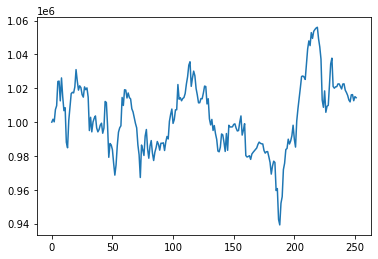

In [82]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [83]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.014444
Cumulative returns     0.014444
Annual volatility      0.109590
Sharpe ratio           0.186033
Calmar ratio           0.155126
Stability              0.013466
Max drawdown          -0.093113
Omega ratio            1.032903
Sortino ratio          0.257143
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.008407
Daily value at risk   -0.013726
dtype: float64


In [84]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)
Annual return          0.076357
Cumulative returns     0.076042
Annual volatility      0.128444
Sharpe ratio           0.639265
Calmar ratio           0.766080
Stability              0.396026
Max drawdown          -0.099672
Omega ratio            1.110797
Sortino ratio          0.907534
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.952372
Daily value at risk   -0.015857
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)


Start date,2021-03-05
End date,2022-03-03
Total months,12
,Backtest
Annual return,1.444%
Cumulative returns,1.444%
Annual volatility,10.959%
Sharpe ratio,0.19
Calmar ratio,0.16
Stability,0.01
Max drawdown,-9.311%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.31,2021-08-17,2021-12-01,2022-01-04,101
1,6.18,2021-04-05,2021-06-18,2021-08-16,96
2,4.76,2022-01-14,2022-01-26,NaT,NaN
3,4.02,2021-03-17,2021-03-24,2021-04-05,14
4,1.14,2021-03-15,2021-03-16,2021-03-17,3


Stress Events,mean,min,max
New Normal,0.01%,-2.33%,1.98%


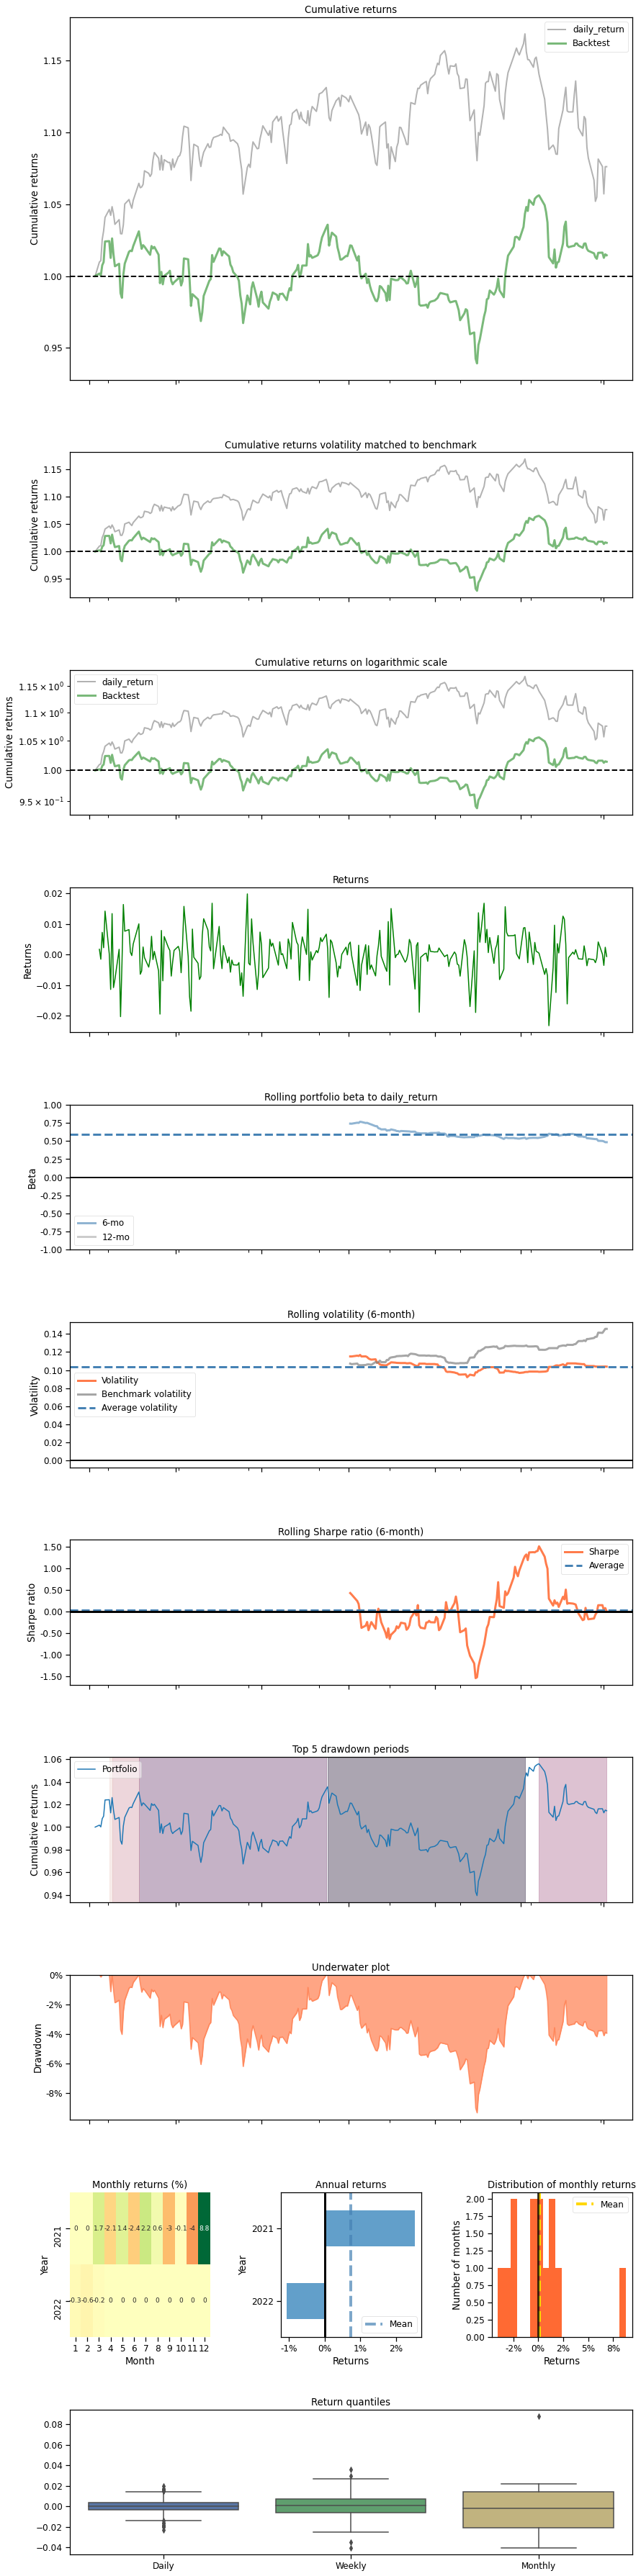

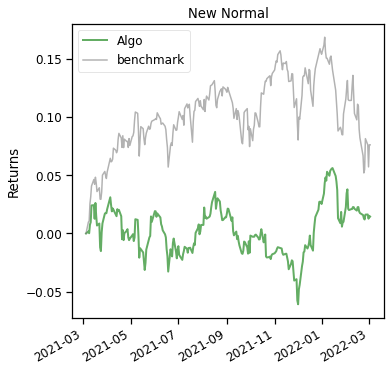

In [85]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])